<a href="https://colab.research.google.com/github/R4HUL-ROY/Multimodal_feature_extraction/blob/main/VGG_16_transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pathlib
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data_root = pathlib.Path('/content/drive/MyDrive/Tobacco3482-jpg/')

print(data_root)
for item in data_root.iterdir():
  print(item)

/content/drive/MyDrive/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/ADVE
/content/drive/MyDrive/Tobacco3482-jpg/Form
/content/drive/MyDrive/Tobacco3482-jpg/Note
/content/drive/MyDrive/Tobacco3482-jpg/Email
/content/drive/MyDrive/Tobacco3482-jpg/News
/content/drive/MyDrive/Tobacco3482-jpg/Resume
/content/drive/MyDrive/Tobacco3482-jpg/Scientific
/content/drive/MyDrive/Tobacco3482-jpg/Memo
/content/drive/MyDrive/Tobacco3482-jpg/Report
/content/drive/MyDrive/Tobacco3482-jpg/Letter


In [3]:
def get_file_paths_and_labels(data_root):
     img_paths = [str(path) for path in data_root.glob('*/*.jpg')]
     labels = [p.split("/")[-2] for p in img_paths]
     return img_paths, labels

img_paths, labels = get_file_paths_and_labels(data_root)
print(img_paths)
print(labels)
print(len(img_paths))
print(len(labels))

['/content/drive/MyDrive/Tobacco3482-jpg/ADVE/0000136188.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/0000435350.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/0030049569.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/0000556056.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03496270.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/0030048095.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03722789.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03567810.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/0030048989.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/04412344.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/04233037_04233039.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/04102204.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/04106546.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/1002760819.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/1002761179.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/1002325458.jpg', '/content/dr

In [4]:
df = pd.DataFrame(list(zip(img_paths, labels)),
               columns =['image_path', 'data_label'])
df.head()

,image_path,data_label
0,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
1,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
2,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
3,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
4,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03...,ADVE


In [5]:
balance=df['data_label'].value_counts()
print (balance)

Memo          620
Email         599
Letter        567
Form          431
Report        265
Scientific    261
ADVE          230
Note          201
News          188
Resume        120
Name: data_label, dtype: int64


In [6]:
train_df, dummy_df=train_test_split(df, test_size=0.3, shuffle=True, stratify= df["data_label"].values, random_state=0)
test_df, valid_df= train_test_split(dummy_df, test_size=0.5, shuffle=True, stratify= dummy_df["data_label"].values, random_state=0)
print (f"train size: {len(train_df)} test size: {len(test_df)}  valid size: {len(valid_df)}")
length=len(test_df)

train size: 2437 test size: 522  valid size: 523


In [7]:
batch_size=32
seed_value = 42
def scalar(x):
    return x/127.5-1 # rescales pixels to range -1 to +1

trgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)

train_gen=trgen.flow_from_dataframe(train_df, x_col='image_path', y_col='data_label', target_size=(150,150), class_mode='categorical',batch_size=batch_size, shuffle=True, seed=seed_value)

tvgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)

valid_gen=tvgen.flow_from_dataframe(valid_df, x_col='image_path', y_col='data_label', target_size=(150,150), class_mode='categorical',batch_size=batch_size, shuffle=False, seed=seed_value)

# determine test generator batch size and steps to go through the test set exactly once for predictions
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]  

test_steps=int(length/test_batch_size)

test_gen=tvgen.flow_from_dataframe(test_df, x_col='image_path', y_col='data_label', target_size=(150,150), class_mode='categorical',batch_size=test_batch_size, shuffle=False, seed=seed_value)

test_labels=test_gen.labels

Found 2437 validated image filenames belonging to 10 classes.
Found 523 validated image filenames belonging to 10 classes.
Found 522 validated image filenames belonging to 10 classes.


In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

img_shape=(150,150,3)
class_count = len(set(df['data_label']))
dropout=0.2
lr= 0.001
seed_value = 42


base_model= VGG16(include_top=False,
                   input_shape=(150,150,3),
                   pooling='avg',classes=10,
                   weights='imagenet')

base_model.trainable=False

inputs = keras.Input(shape=img_shape)
x = base_model(inputs, training=False)

# x=tf.keras.layers.Dropout(rate=dropout, seed=seed_value)(x)
x =tf.keras.layers.Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=seed_value))(x)
# x=tf.keras.layers.Dropout(rate=dropout, seed=seed_value)(x)
outputs=tf.keras.layers.Dense(class_count, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value))(x)
model=Model(inputs, outputs)

model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5", verbose=1, monitor='val_loss',save_best_only=True, mode='auto') 

history=model.fit(x=train_gen,  epochs=50, verbose=2, validation_data=valid_gen, callbacks=[checkpoint],
               validation_steps=None,  shuffle=False,  initial_epoch=0)

# history = model.fit(train_gen, validation_data=valid_gen,verbose=2, epochs=20)

Epoch 1/50

Epoch 1: val_loss improved from inf to 2.22449, saving model to /model-001-0.515388-0.520076.h5
77/77 - 139s - loss: 2.5058 - accuracy: 0.5154 - val_loss: 2.2245 - val_accuracy: 0.5201 - 139s/epoch - 2s/step
Epoch 2/50

Epoch 2: val_loss improved from 2.22449 to 1.97908, saving model to /model-002-0.548215-0.560229.h5
77/77 - 87s - loss: 2.0581 - accuracy: 0.5482 - val_loss: 1.9791 - val_accuracy: 0.5602 - 87s/epoch - 1s/step
Epoch 3/50

Epoch 3: val_loss improved from 1.97908 to 1.85509, saving model to /model-003-0.582684-0.577438.h5
77/77 - 83s - loss: 1.8796 - accuracy: 0.5827 - val_loss: 1.8551 - val_accuracy: 0.5774 - 83s/epoch - 1s/step
Epoch 4/50

Epoch 4: val_loss improved from 1.85509 to 1.77276, saving model to /model-004-0.580632-0.581262.h5
77/77 - 84s - loss: 1.7709 - accuracy: 0.5806 - val_loss: 1.7728 - val_accuracy: 0.5813 - 84s/epoch - 1s/step
Epoch 5/50

Epoch 5: val_loss improved from 1.77276 to 1.70674, saving model to /model-005-0.593352-0.586998.h5
77

In [12]:
epochs = 50
base_model.trainable=True
fine_tune_epochs= 20
total_epochs=epochs + fine_tune_epochs

model.compile(Adamax(learning_rate=lr/10), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________


In [13]:
history_fine = model.fit(x=train_gen,  epochs=total_epochs, verbose=2, validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=epochs)

Epoch 51/70
77/77 - 102s - loss: 1.4587 - accuracy: 0.5934 - val_loss: 1.1932 - val_accuracy: 0.6730 - 102s/epoch - 1s/step
Epoch 52/70
77/77 - 95s - loss: 1.0194 - accuracy: 0.7345 - val_loss: 1.0584 - val_accuracy: 0.7208 - 95s/epoch - 1s/step
Epoch 53/70
77/77 - 94s - loss: 0.8683 - accuracy: 0.7965 - val_loss: 0.9954 - val_accuracy: 0.7419 - 94s/epoch - 1s/step
Epoch 54/70
77/77 - 95s - loss: 0.7764 - accuracy: 0.8244 - val_loss: 0.9341 - val_accuracy: 0.7763 - 95s/epoch - 1s/step
Epoch 55/70
77/77 - 99s - loss: 0.6494 - accuracy: 0.8670 - val_loss: 0.9452 - val_accuracy: 0.7859 - 99s/epoch - 1s/step
Epoch 56/70
77/77 - 100s - loss: 0.5735 - accuracy: 0.8945 - val_loss: 0.9491 - val_accuracy: 0.7686 - 100s/epoch - 1s/step
Epoch 57/70
77/77 - 100s - loss: 0.5037 - accuracy: 0.9192 - val_loss: 0.9065 - val_accuracy: 0.7935 - 100s/epoch - 1s/step
Epoch 58/70
77/77 - 98s - loss: 0.4764 - accuracy: 0.9343 - val_loss: 0.9133 - val_accuracy: 0.7916 - 98s/epoch - 1s/step
Epoch 59/70
77/77 

In [14]:
model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=True)

18/18 [==============================] - 160s 9s/step - loss: 0.8401 - accuracy: 0.8065


{'accuracy': 0.8065134286880493, 'loss': 0.840088427066803}

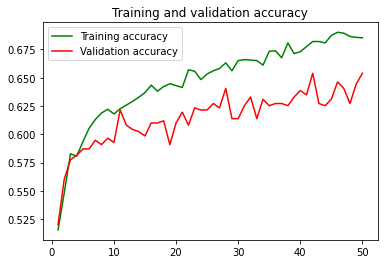

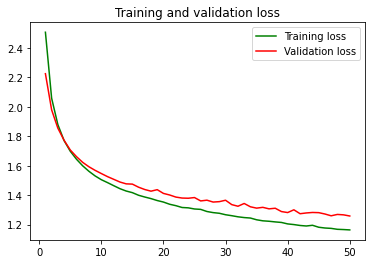

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

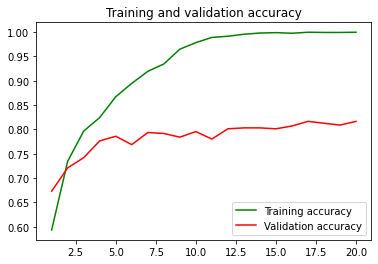

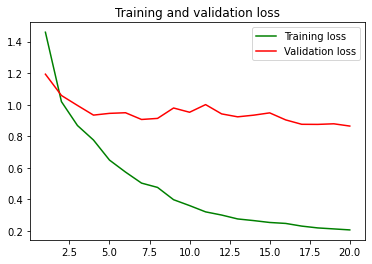

In [16]:
import matplotlib.pyplot as plt

acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()